In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

from IPython.display import display
from tools import make_track, ols_regression, make_ER, lasso_regression, lasso_regression_2
from hc_graph import hc_stock

<IPython.core.display.Javascript object>

Open console to check js libs were loaded in page


### Financial data loads and cleaning

In [3]:
# BNP Data
#bnp = pd.read_csv(r'financial_data/bnp_data.csv', parse_dates =True, sep=";", header= [3], index_col=0)
#bnp_wanted_ticker = ["US_USDLIBOR3M","USD_EUR"]
#bnp

In [4]:
# yahoo_prices
yahoo = pd.read_csv(r"financial_data/yahoo_prices.csv", index_col=0, parse_dates=True, dayfirst=True)

# MSCI
msci = pd.read_csv(r'financial_data/msci_data.csv', index_col=0, parse_dates=True, sep=";")

# US rate
US_rate = pd.read_csv(r"financial_data/USD_rates.csv", index_col=0, parse_dates=True, dayfirst=True)['3M']

# HFRX
hfrx_all = pd.read_csv(r"financial_data/hfrx_daily_index_data.csv", index_col=0, parse_dates=True, dayfirst=True).ffill()
hfrx = make_ER(hfrx_all[['HFRXEMN']].dropna(), US_rate)

# BNP
bnp_all = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU',
                            'BNPIFUS', 'BNPIFJP', 'BNPIFCN', 'BNPIFFR', 'BNPIFGE', 'BNPIFGB', 'BNPIFCH', 'BNPIFKR',
                            'BNPIFUSC', 'BNPIFBR', 'BNPIFAU', 'BNPIFHK', 'BNPIFTW', 'BNPIFSG', 'BNPIFIT', 'BNPIFSP',
                            'BNPIFSW', 'BNPIFNE', 'BNPIFRU', 'BNPIFEM', 'BNPIFJT', 'BPFXEUR1', 'BPFXGBP1', 'BPFXCHF1',
                            'BPFXJPY1', 'BPFXAUD1', 'BPFXNZD1', 'BPFXNOK1', 'BPFXSEK1', 'BPFXCAD1', 'BPFXCZK1',
                            'BPFXPLN1', 'BPFXHUF1', 'BPFXTRY1', 'BPFXZAR1', 'BPFXSGD1', 'BPFXMXN1', 'BPFXINR1',
                            'BPFXKRW1', 'BPFXPHP1', 'BPFXTWD1', 'BPFXBRL1', 'BPFXCLP1', 'BPFXCOP1']]
bnp = pd.read_csv(r"financial_data/bnp_data.csv", index_col=0, parse_dates=True, dayfirst=True)[['BNPIFEU', 'BNPIFUS', 'BNPIFUSC',
                            'BNPIFJP', 'BNPIFGB', 'BNPIFCH', 'BNPIFEM', 'BPFXEUR1', 'BPFXGBP1', 'BPFXJPY1']]

In [5]:
prices = bnp.copy()
#prices = prices.join(msci, how="outer")
prices = prices.join(hfrx,how="outer")

prices_all = bnp_all.copy()
#prices = prices.join(msci, how="outer")
prices_all = prices_all.join(hfrx,how="outer")

In [6]:
starts = prices.apply(lambda x:x.first_valid_index())

In [7]:
prices = prices.ffill().dropna()
returns = prices.resample('7D').first().pct_change().dropna()

prices_all = prices_all.ffill().dropna()
returns_all = prices_all.resample('7D').first().pct_change().dropna()

In [19]:
hrfx_returns = returns[["HFRXEMN"]]
bch_returns = returns.drop("HFRXEMN", axis=1)
bch_returns_all = returns_all.drop("HFRXEMN", axis=1)

size = 52
freq = 13
bounds = (-np.inf,np.inf)
total_weight = np.nan

df_weight = ols_regression(hrfx_returns, bch_returns, size, freq, boundaries=bounds, weight_sum=total_weight)
df_weight_all = ols_regression(hrfx_returns, bch_returns_all, size, freq, boundaries=bounds, weight_sum=total_weight)

prices_for_track = prices.loc[df_weight.index[0]:].drop("HFRXEMN", axis=1)
replication = make_track(prices_for_track, df_weight)

prices_for_track_all = prices_all.loc[df_weight_all.index[0]:].drop("HFRXEMN", axis=1)
replication_all = make_track(prices_for_track_all, df_weight_all)

df_res = prices.loc[replication.index][["HFRXEMN"]]
df_res["OLS"] = replication
df_res["OLS all"] = replication_all

In [28]:
df_weight_lasso = lasso_regression(hrfx_returns, bch_returns_all, size, freq, boundaries=bounds, weight_sum=total_weight, l=0.02)
replication_lasso = make_track(prices_for_track_all, df_weight_lasso)
df_res["Lasso"] = replication_lasso

In [29]:
df_weight_lasso2 = lasso_regression_2(hrfx_returns, bch_returns_all, size, freq, boundaries=bounds,
                                       weight_sum=total_weight, l1=0.02, l2=1.5)
replication_lasso2 = make_track(prices_for_track_all, df_weight_lasso2)
df_res["Lasso 2"] = replication_lasso2
df_res = df_res / df_res.iloc[0]

In [32]:
df_weight

,BNPIFEU,BNPIFUS,BNPIFUSC,BNPIFJP,BNPIFGB,BNPIFCH,BNPIFEM,BPFXEUR1,BPFXGBP1,BPFXJPY1
2008-01-09,-0.119187,-0.313936,0.201837,0.092121,-0.088182,0.291479,0.016786,0.022533,-0.128006,0.014020
2008-04-09,0.099067,-0.312117,0.111369,0.031415,0.076130,0.049038,0.012311,-0.032756,-0.101807,-0.010185
2008-07-09,0.068200,-0.139857,0.029817,0.039704,0.091042,-0.042026,-0.005085,0.013792,-0.036573,-0.075418
2008-10-08,0.066347,-0.000849,-0.060431,0.049334,0.023383,-0.098360,0.025143,0.074837,-0.066299,-0.074193
2009-01-07,0.003194,0.333179,-0.196786,0.027099,-0.065046,-0.074554,-0.059168,0.174591,-0.189974,-0.164981
2009-04-08,-0.052653,0.229167,-0.128806,0.038872,0.003995,-0.090052,-0.055291,0.022206,-0.042764,-0.021490
2009-07-08,-0.030944,0.014988,-0.023454,-0.016941,0.008963,0.004690,-0.017326,0.020904,-0.011285,-0.028173
2009-10-07,0.030911,0.039911,-0.022616,-0.032767,0.035929,-0.021280,-0.077492,0.048735,-0.027682,-0.063940
2010-01-06,0.061477,-0.034911,0.001673,-0.040733,0.071194,-0.031883,-0.067081,0.018333,0.004726,-0.022225
2010-04-07,0.003098,-0.092574,0.023480,0.002790,0.108293,0.029217,-0.053976,-0.019905,0.093312,-0.008320


In [35]:
df_weight_lasso[df_weight.columns]/df_weight

,BNPIFEU,BNPIFUS,BNPIFUSC,BNPIFJP,BNPIFGB,BNPIFCH,BNPIFEM,BPFXEUR1,BPFXGBP1,BPFXJPY1
2008-01-09,8.302387e-05,-1.010072e-05,6.200115e-06,0.000056,-0.000205,1.843115e-01,1.026663e-04,-0.000731,-0.000029,-7.844975e-04
2008-04-09,-2.835086e-07,-3.272636e-05,-5.130264e-06,0.000619,0.000037,6.960863e-04,-6.174657e-04,0.001883,0.000349,3.698587e-03
2008-07-09,7.049311e-05,-4.443467e-07,-4.191445e-05,0.000013,-0.000011,9.721500e-06,-9.744431e-05,-0.000697,-0.000123,1.024025e-04
2008-10-08,-1.138682e-05,-1.051689e-02,1.658872e-04,0.000888,0.004498,-1.481899e-05,2.166886e-04,0.000007,-0.000096,4.850520e-02
2009-01-07,2.711679e-04,-3.790597e-05,1.369277e-02,0.000033,0.000017,1.838607e-04,-4.399523e-05,0.000049,0.000024,-3.391238e-06
2009-04-08,5.701926e-04,-3.110544e-05,3.477691e-02,-0.000058,-0.002200,2.304136e-04,-1.254106e-05,0.000493,0.000060,-2.383881e-04
2009-07-08,2.653298e-05,-1.681240e-03,2.336710e-04,-0.000003,0.000017,-3.693808e-04,1.902468e-04,-0.000088,-0.000032,2.211470e-05
2009-10-07,1.745286e-04,-2.926192e-04,3.398462e-03,0.000064,0.000117,3.700394e-04,1.281800e-01,0.000004,0.000342,4.982568e-07
2010-01-06,8.471765e-06,3.672605e-05,-6.512101e-05,0.000002,0.000007,-5.103200e-05,1.665596e-06,0.000029,0.000443,4.919337e-05
2010-04-07,5.427629e-04,1.432789e-04,-6.762149e-06,0.010422,-0.000145,3.425834e-03,1.590010e-04,-0.000713,0.002327,-1.959166e-02


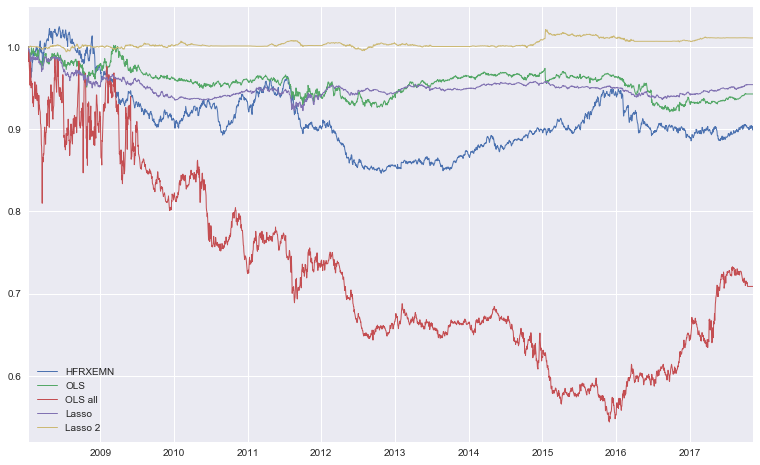

In [36]:
df_res.plot(figsize=(13,8), linewidth=1)

In [31]:
g = hc_stock(df_res)
g.plot()

In [37]:
df_res.pct_change().corr(method="pearson")

,HFRXEMN,OLS,OLS all,Lasso,Lasso 2
HFRXEMN,1.000000,0.060956,0.042615,0.084622,-0.045073
OLS,0.060956,1.000000,0.110170,0.417654,0.029090
OLS all,0.042615,0.110170,1.000000,0.129207,0.092917
Lasso,0.084622,0.417654,0.129207,1.000000,0.092664
Lasso 2,-0.045073,0.029090,0.092917,0.092664,1.000000


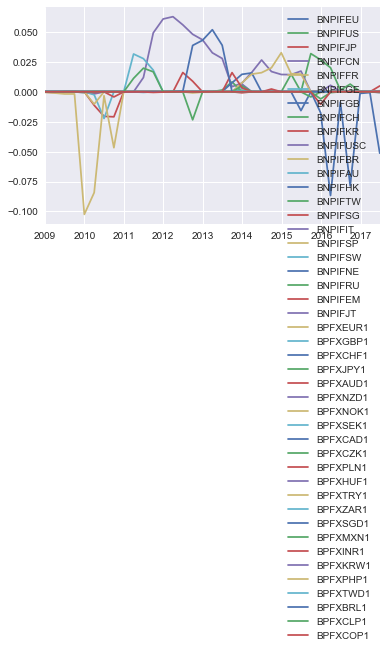

In [14]:
df_weight_lasso.plot()